In [416]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np


In [417]:
#read the file tech_review_channels.tsv.gz
Tch_chan = pd.read_pickle("tech_review_channels (1).p",compression='gzip')
Tech_videos = pd.read_csv('yt_tech_channels_metadata.tsv.gz',compression='infer',sep='\t')
TS = pd.read_table("df_timeseries_en.tsv")

Here in those two plots , I divided the tech youtubers within bings, using two metrics (numerical tresholds and percentiles), and measured the average upload frequency depending where they are, we can observe that youtubers that upload the less are small youtubers (0-10th percentile), as they are only doing it for hobby and probably have something else besides youtube, this augments clearly when they are in the 2nd bin, because they are putting a lot of efforts to be known and followed, so they have to push a lot of videos to be seen the most possible. Afterwards this upload frequency is surrounding 7 videos per week , that is here about 2 videos per week , and that's what common youtubers do in general, this frequency increases again for top tier youtubers, and this is probably because it's their main job (this is told by personal knowledge). The trend is the same as in the first plot , and we want to focus more on detail to see if there is a correlation or not between the frequency and the number of subscribers

# Now , focus only on 4 youtubers , this will be generalized over bunch of youtubers for each category 


In [418]:
Tech_videos['upload_date'] = pd.to_datetime(Tech_videos['upload_date'])
# Sort the DataFrame by channels then release date
Tech_videos = Tech_videos.sort_values(['channel_id', 'upload_date'])


In [419]:
# filter time series such the it contains only the channels in Tch_chan
TS_Tech = TS[TS['channel'].isin(Tch_chan['channel_id'])]

In [420]:
Tech_videos =Tech_videos[(TS_Tech['datetime'].max() >=Tech_videos['upload_date']) & (Tech_videos['upload_date']>= TS_Tech['datetime'].min())]
Tech_videos = Tech_videos.sort_values('upload_date')
TS_Tech = TS_Tech.sort_values('datetime')


In [421]:
bin_edges = [0 ,10000,  50000, 100000, 500000, 1000000,2500000,  5000000, float('inf')]
# Create a new column to categorize subscribers into bins
TS_Tech['Subs_Cat'] = pd.cut(TS_Tech['subs'], bins=bin_edges)
#Putting youtubers in categories depending on their subs_cat, cateogories must be between 1 and 10 
TS_Tech['Rank_Cat'] = 8-TS_Tech['Subs_Cat'].cat.codes 


([<matplotlib.patches.Wedge at 0x7f9d35c94c70>,
 [Text(0.7428232523270022, 0.8113036520331551, '(0.0, 10000.0]'),
  Text(-1.0492719616224302, 0.3301944132674224, '(10000.0, 50000.0]'),
  Text(-0.3378023605966107, -1.0468474412135502, '(50000.0, 100000.0]'),
  Text(0.6368417222841368, -0.8969016784231003, '(100000.0, 500000.0]'),
  Text(1.0526056908163852, -0.31940767000959885, '(500000.0, 1000000.0]'),
  Text(1.0925266056199456, -0.12800631239341206, '(1000000.0, 2500000.0]'),
  Text(1.099229695585821, -0.04115915866856055, '(2500000.0, 5000000.0]'),
  Text(1.099937393639908, -0.011735845629799964, '(5000000.0, inf]')])

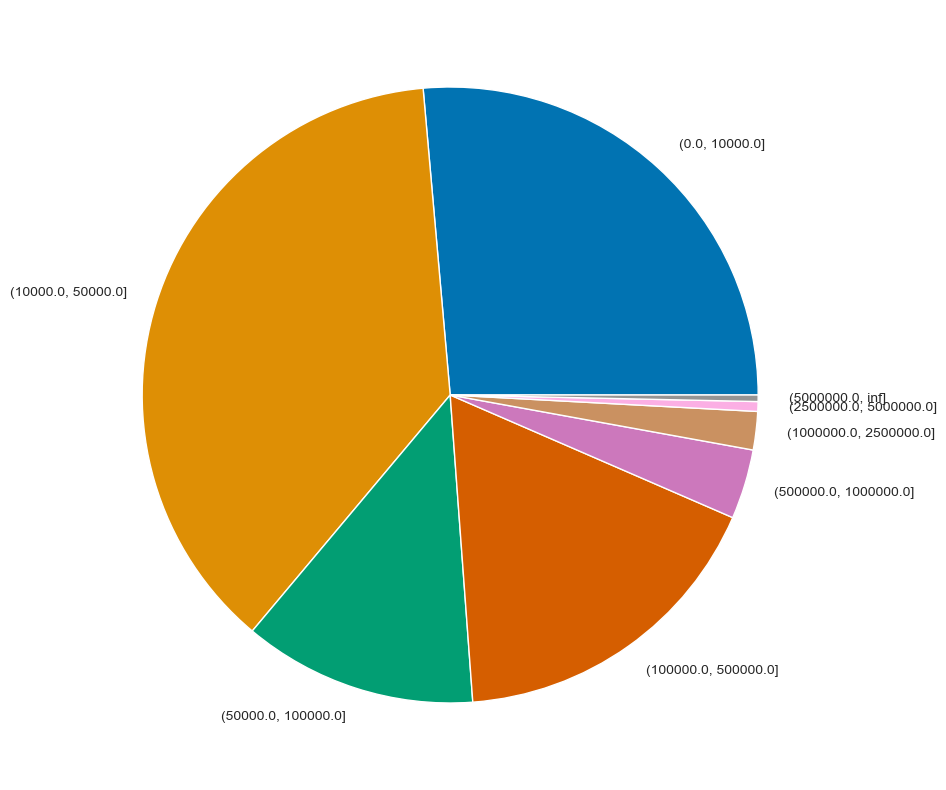

In [422]:

#pie chart of the number of channels in each category, using the colourblind of sns
sns.set_palette("colorblind")
plt.figure(figsize=(10,10))
plt.pie(TS_Tech.groupby('Subs_Cat')['channel'].count(),labels=TS_Tech.groupby('Subs_Cat')['channel'].count().index)

Before all, let's observe the repartition of our set of study, most of the youtubers are small, indeed, almost 2 tech youtubers over 3  have between 0 and 50 000 subscribers, and only a small part of them has more than 500k subscribers.
So We decided to split the data in categories to observe the relation between the regularity and the growth rate of those channels.

In [423]:
tech_mt_uf = Tech_videos.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date


first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(days=1)
#change the delay into number of days
tech_df_upload_freq.delay = (tech_df_upload_freq.delay / np.timedelta64(1, 'D')).astype(float)

#change all 0 by 1/(number of videos published in the same day)
tech_df_upload_freq.loc[tech_df_upload_freq.delay==0,'delay'] \
    = 1/tech_df_upload_freq.loc[tech_df_upload_freq.delay==0].groupby(['channel_id','upload_date']).delay.transform('count')


tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_upload_freq['upload_day'] = tech_df_upload_freq.upload_date.dt.day

#compute the standard deviation of the frequency of uploads per month (how much does the frequency of uploads vary within a month)
tech_df_upload_freq['frequency'] = 1/tech_df_upload_freq.delay
tech_df_upload_freq['frequency_monthly_std']= tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['frequency'].transform('std')
# Changing 0 std to the smallest non-zero value (to avoid division by 0)
tech_df_upload_freq['frequency_monthly_std'] = tech_df_upload_freq['frequency_monthly_std'].replace(0, np.nan)
smallest_nonzero = tech_df_upload_freq['frequency_monthly_std'].min()
tech_df_upload_freq['frequency_monthly_std'] = tech_df_upload_freq['frequency_monthly_std'].fillna(smallest_nonzero)

#compute the number of likes per views for each video, which is a metric of quality content
tech_df_upload_freq['likes_per_views'] = tech_df_upload_freq['like_count'] / tech_df_upload_freq['view_count']
tech_df_upload_freq['monthly_avg_likes_per_views'] = tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['likes_per_views'].transform('mean')

#compute the number of videos uploaded per month for each channel
tech_df_upload_freq['monthly_vids']=tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['display_id'].transform('count')


#select the columns we need
tch_monthly_data = tech_df_upload_freq[['channel_id','upload_year', 'upload_month','monthly_vids', 'frequency_monthly_std','monthly_avg_likes_per_views' ]]
tch_monthly_data.sort_values(by=['upload_year', 'upload_month','channel_id'],ascending=True,inplace=True)



/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/220636464.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [424]:
TS_Tech['datetime'] = pd.to_datetime(TS_Tech["datetime"])
TS_Tech['year'] = TS_Tech['datetime'].dt.year
TS_Tech['month'] = TS_Tech['datetime'].dt.month
TS_Tech['monthly_delta_subs']= TS_Tech.groupby(['channel','year','month'])['delta_subs'].transform('sum')
TS_Tech['monthly_subs']= TS_Tech.groupby(['channel','year','month'])['subs'].transform('min')
#We assumed here that you never started with 0 subscribers, so we replaced the 0 by 1 , to avoid division by 0
TS_Tech.loc[TS_Tech.monthly_subs==0,'monthly_subs'] = 1

#compute the monthly growth rate of subscribers
TS_Tech['monthly_subs_growth']= TS_Tech['monthly_delta_subs']/TS_Tech['monthly_subs']
TS_Tech['monthly_subs_growth'].fillna(0,inplace=True)

#xompute the category where the channel lies in each month, as some of them change categories
TS_Tech['monthly_subs_cat']=TS_Tech.groupby(['channel','year','month'])['Subs_Cat'].transform('max')
TS_Tech['monthly_rank']= TS_Tech.groupby(['channel','year','month'])['Rank_Cat'].transform('min')



TS_Monthly = TS_Tech[['channel','year','month','monthly_subs','monthly_subs_growth','monthly_subs_cat','monthly_rank']].drop_duplicates()




In [425]:
tch_monthly_data.rename({'channel_id':'channel', 'upload_year':'year', 'upload_month':'month'},axis=1,inplace=True)

#merge the two dataframes and fill the NaN values with 0
mergedmonthly = pd.merge(TS_Monthly,tch_monthly_data,on=['channel','year','month'],how='left')
mergedmonthly['monthly_vids'].fillna(0,inplace=True)
mergedmonthly['frequency_monthly_std'].fillna(0,inplace=True)
mergedmonthly['monthly_avg_likes_per_views'].fillna(0,inplace=True)

#define the monthly regularity metric as #videos * log(1+ 1/standard deviation of the frequency of uploads per month)
#This metric is a measure of how regular the youtuber is in terms of uploads , and we take the log to advantage youtubers who are more regular (low std)
mergedmonthly['monthly_regularity']= 1/mergedmonthly['frequency_monthly_std']
mergedmonthly['monthly_regularity'].fillna(0,inplace=True)
mergedmonthly['monthly_regularity'] = np.log(1+mergedmonthly['monthly_regularity'])
mergedmonthly['monthly_regularity'] = mergedmonthly['monthly_vids']*mergedmonthly['monthly_regularity']
mergedmonthly['monthly_regularity'].fillna(0,inplace=True)
mergedmonthly.drop_duplicates(inplace=True)


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/750618746.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [426]:
#let only the months and years where all categories are present (from october 2016):
mergedmonthly = mergedmonthly[(mergedmonthly['year']>2016) | (mergedmonthly['month']>9)]

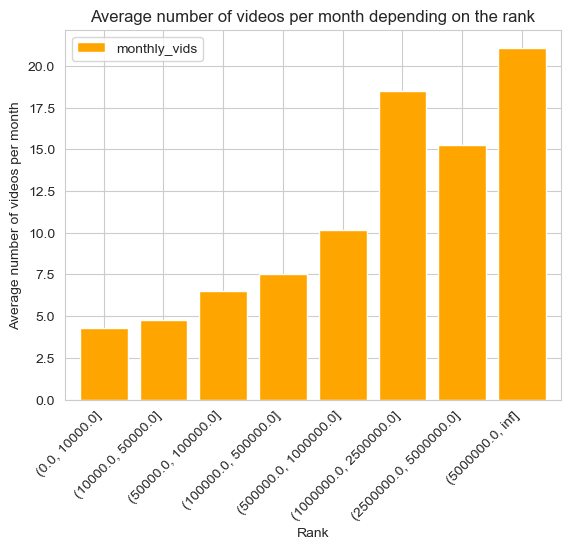

In [427]:
avg_vids_per_month = mergedmonthly.groupby(['monthly_subs_cat'],as_index=False)[['monthly_vids']].mean()
#potting the average number of videos per month depending on the rank
avg_vids_per_month.plot(kind='bar',x='monthly_subs_cat', y='monthly_vids', width=0.8, color='orange')
plt.title('Average number of videos per month depending on the rank')
plt.xlabel('Rank')
plt.ylabel('Average number of videos per month')
plt.xticks(rotation=45, ha='right')
plt.show()

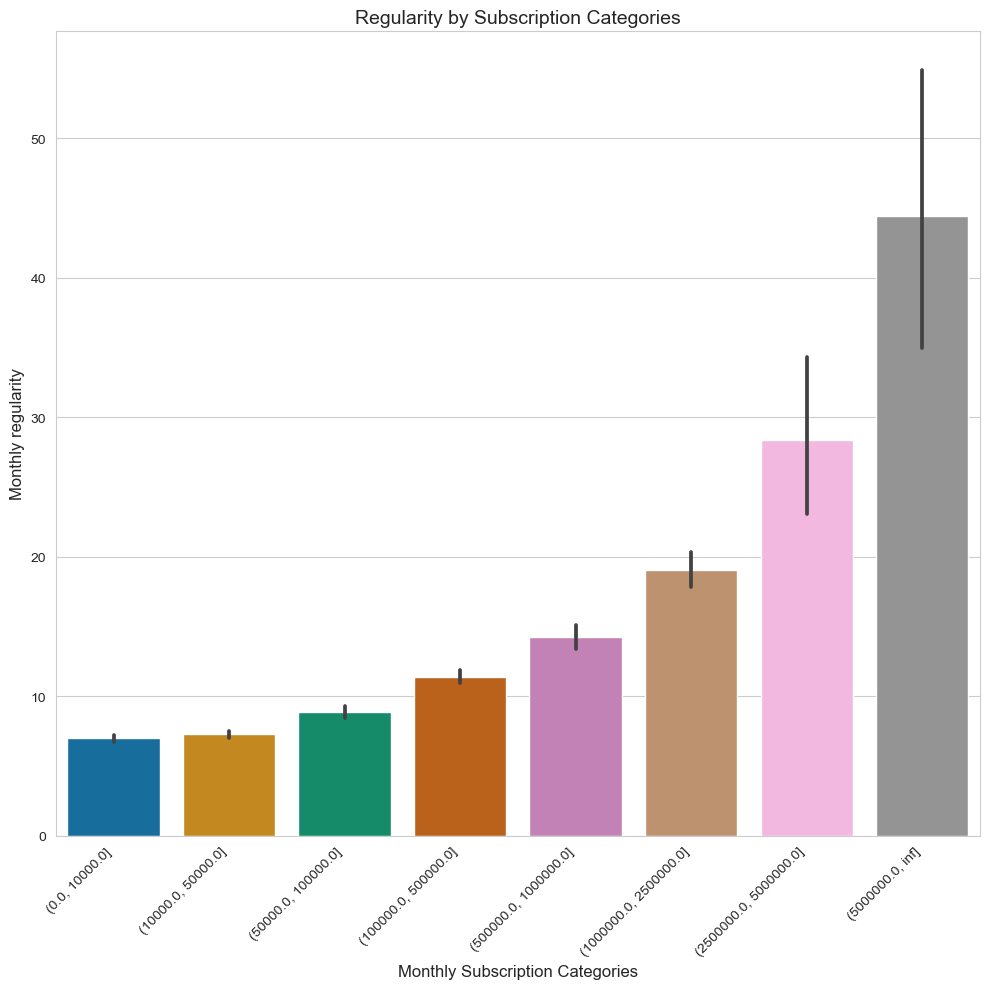

In [429]:
#same as that boxplot but now barplot
# Assuming 'mergedmonthly' is your DataFrame
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")  # Optional: setting seaborn style
sns.barplot(x='monthly_subs_cat', y='monthly_regularity', data=mergedmonthly) 

# Customizing labels and title

plt.xlabel('Monthly Subscription Categories', fontsize=12)
plt.ylabel('Monthly regularity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.title('Regularity by Subscription Categories', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


The main observation that we can do in this case, is that on average, the higher the category (and thus the number of subscribers), the higher the regularity is, and confidence intervals are not overlapping anywhere but in within the first two categories that represent relatively "small" youtubers.

In [430]:
#Here we want to plot the average number of videos per month depending on the categories , so we do some operations grouping by the categories

monthly_avg  = mergedmonthly.groupby(['year', 'month', 'monthly_rank']).agg({
    'monthly_subs_cat':'min',
    'monthly_vids': 'mean',
    'monthly_subs_growth': 'mean',
    'monthly_regularity': 'mean',
    'monthly_avg_likes_per_views': 'mean'
}).reset_index()



/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2172371954.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2172371954.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an under

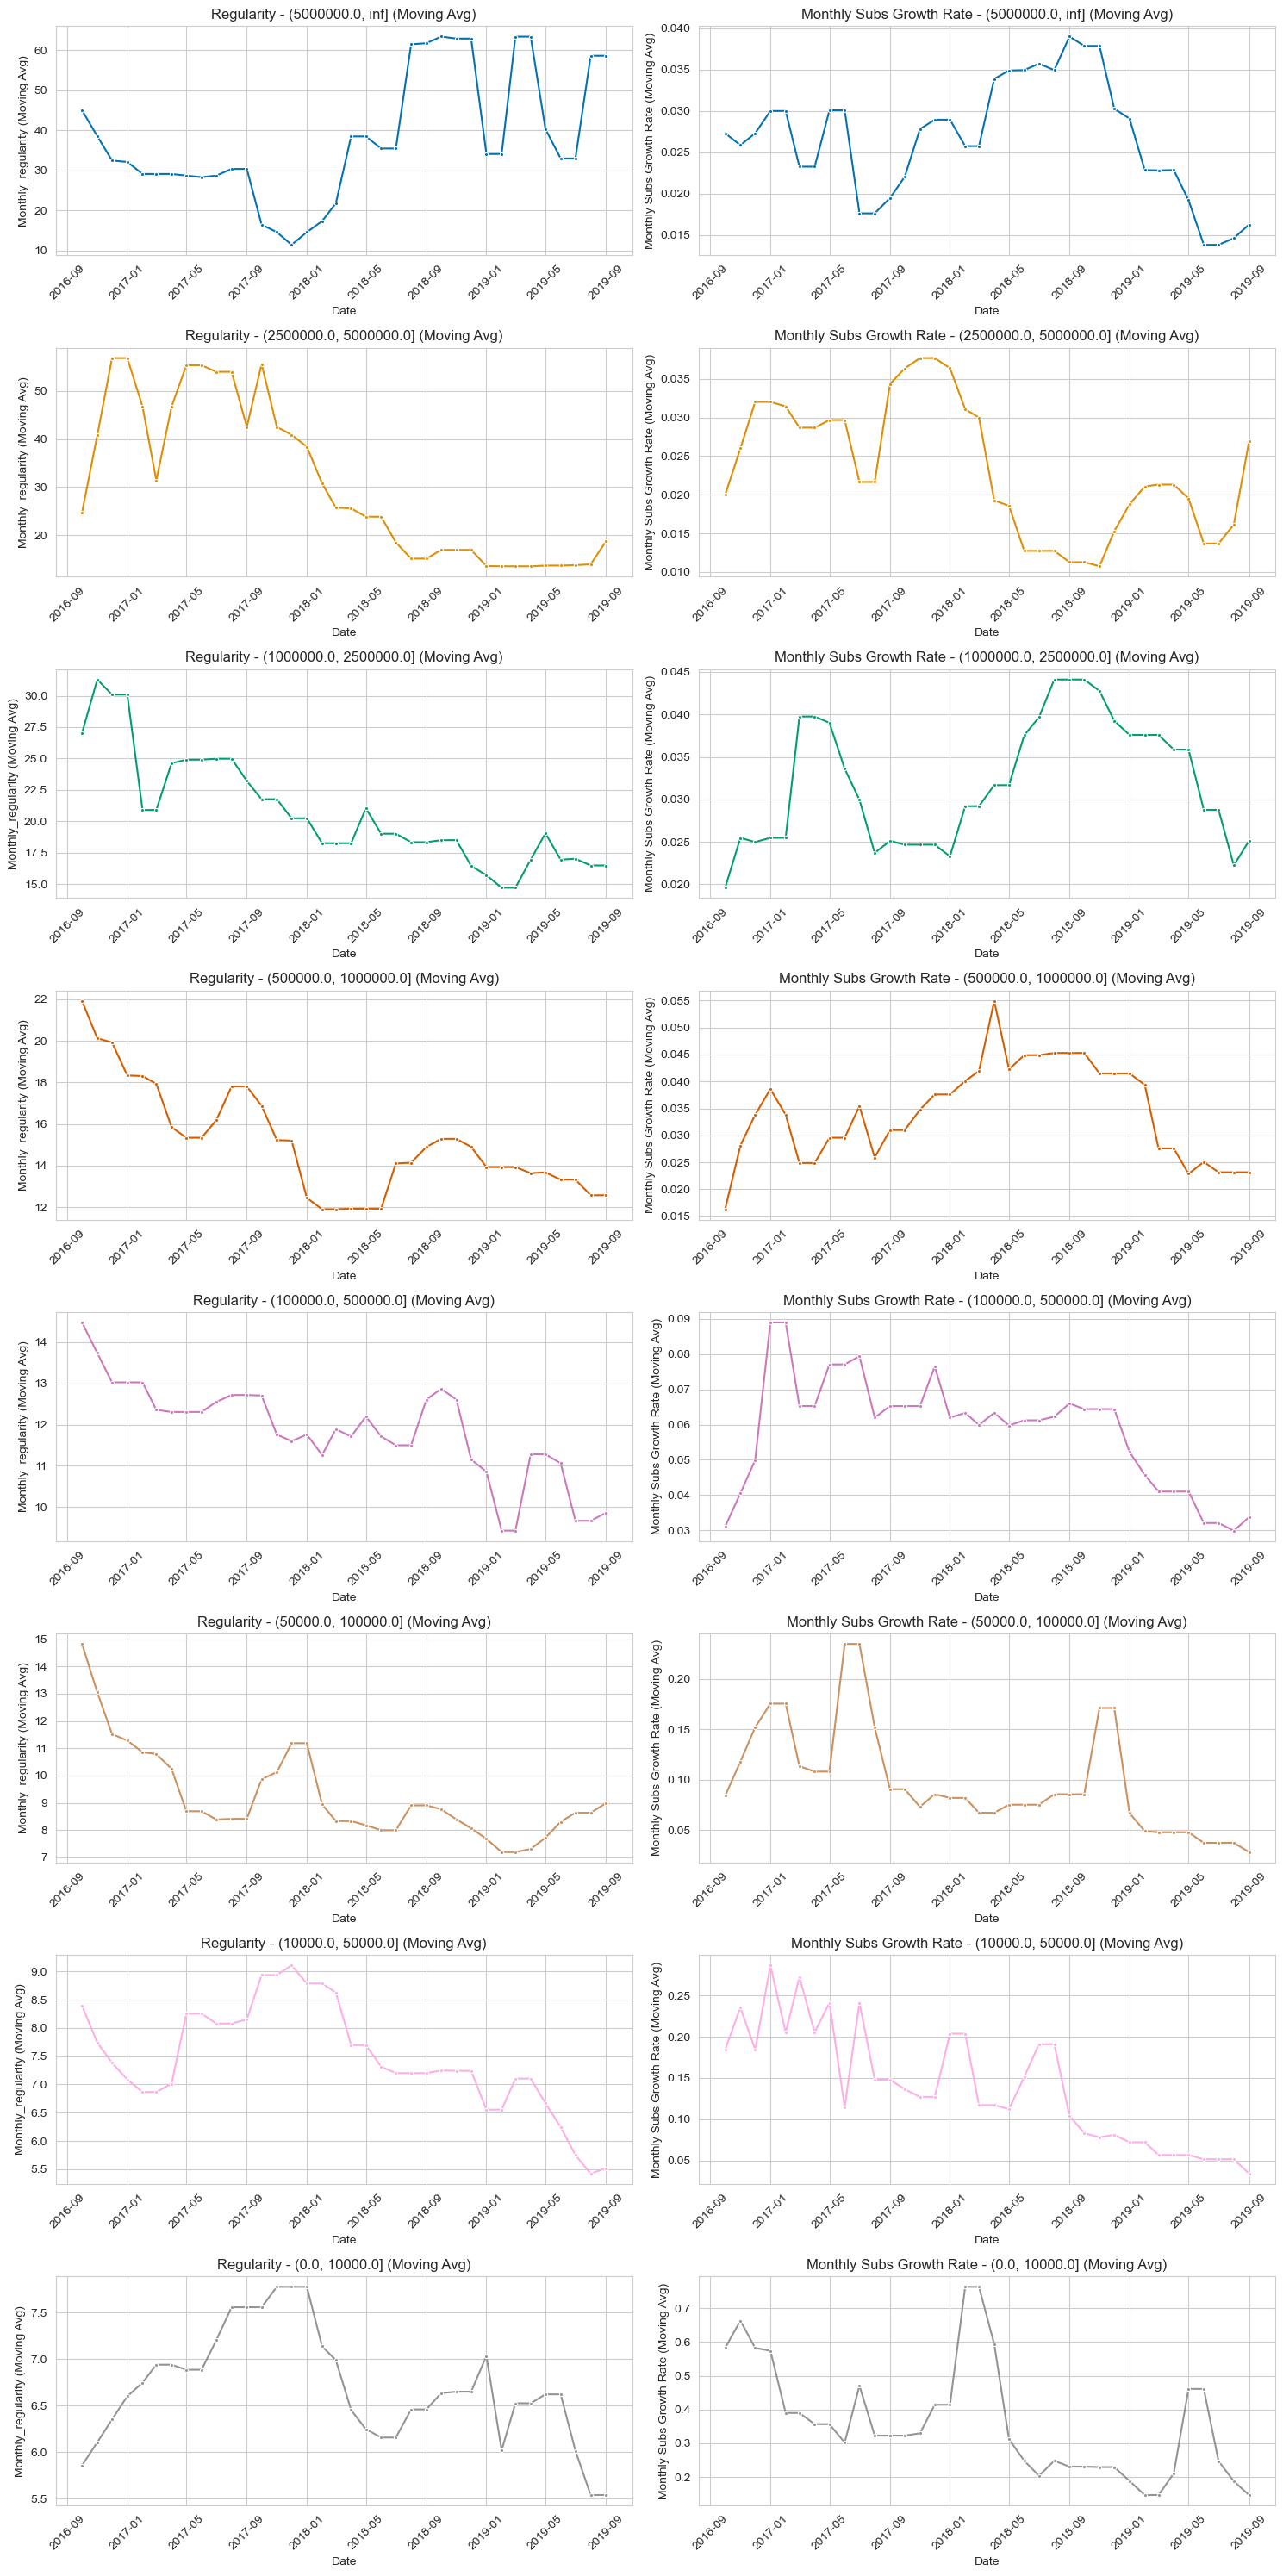

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'monthly_avg' is your DataFrame with 'year', 'month', 'monthly_subs_cat', 'monthly_vids', 'monthly_subs_growth'

# Combine 'year' and 'month' columns to create a 'date' column
monthly_avg['date'] = pd.to_datetime(monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str))

# Get unique categories
categories = monthly_avg['monthly_subs_cat'].unique()

# Create a color palette for different categories
palette = sns.color_palette("colorblind", len(categories))

# Create 8x2 subplots (8 categories, 2 plots each)
fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(15, 30))

# Plotting for each category with moving averages and different colors
for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = monthly_avg[monthly_avg['monthly_subs_cat'] == category]
    
    # Apply moving averages to number of videos per month
    category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).median()
    
    # Plotting number of videos per month with moving averages and different color
    sns.lineplot(data=category_data, x='date', y='monthly_regularity_ma', ax=axes[i, 0], marker='.', estimator=None, color=palette[i])
    axes[i, 0].set_title(f'Regularity - {category} (Moving Avg)')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Monthly_regularity (Moving Avg)')
    axes[i, 0].legend().remove()
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Apply moving averages to monthly subscription growth rate
    category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).median()
    
    # Plotting monthly subscription growth rate with moving averages and different color
    sns.lineplot(data=category_data, x='date', y='monthly_subs_growth_ma', ax=axes[i, 1], marker='.', estimator=None, color=palette[i])
    axes[i, 1].set_title(f'Monthly Subs Growth Rate - {category} (Moving Avg)')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Monthly Subs Growth Rate (Moving Avg)')
    axes[i, 1].legend().remove()
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


While observing those plots, we can globally observe a similar trend between the regularity of youtubers and their growth rate within each month , unless for youtubers that have between 500 000 and 2 500 000 subscribers.
Indeed, while observing a global decrease in the monthly releases (and thus the regularity) of all tech channels categories (except those on the top with more than 5M subscribers), we observe the same global decrease in the subscribers growth , except , for as we said before, youtubers that have between 500 000 and 2 500 000 subscribers, as we can observe an increase in the subscribers growth.

For youtubers that have more than 5 000 0000 subscribers, we can observe that the growth rate fluctuates a lot, as they are only few youtubers within that category so it's more volatile, but the trend is in overall the same as the regularity, and this can be observed also numerically through the spearmann correlation between those two metrics per each category as stated below.

Mooreover, we can also observe a kind of pattern related to all categories (except between 500k and 2.5m), and this is that we observe some jumps in terms of regularity during the end of each year, which coincides with the periods of christmas, thanksgivng , black friday and the relases of video games and cellphones (like Iphones). 

In [432]:
import pandas as pd

# Create an empty list to store correlation data
correlation_data = []

# Calculate Spearman correlations for each category
for category in categories:
    category_data = monthly_avg[monthly_avg['monthly_subs_cat'] == category]
    spearman_corr = category_data[['monthly_regularity', 'monthly_subs_growth']].corr(method='spearman')
    spearman_corr_value = spearman_corr.iloc[0, 1]
    
    # Append correlation data to the list
    correlation_data.append({'Category': category, 'Spearman Correlation': round(spearman_corr_value, 2)})

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data, index = monthly_avg['monthly_rank'].unique())

# Display the correlation table
display(correlation_df)



,Category,Spearman Correlation
1,"(5000000.0, inf]",0.19
2,"(2500000.0, 5000000.0]",0.70
3,"(1000000.0, 2500000.0]",-0.12
4,"(500000.0, 1000000.0]",-0.22
5,"(100000.0, 500000.0]",0.27
6,"(50000.0, 100000.0]",0.43
7,"(10000.0, 50000.0]",0.45
8,"(0.0, 10000.0]",0.24


## Now we want to dig deeper to see why categories 3 and 4 are have a negative correlation between monthly subscribers growth and monthly regularity

In [433]:
# Filter channels that started in category 3 or 4
monthly_data34= mergedmonthly[(mergedmonthly['monthly_rank'] == 3) | (mergedmonthly['monthly_rank'] == 4)]


In [434]:

#same groupby as before but only for the channels that started in category 3 or 4
channels34_avg  = monthly_data34.groupby(['year', 'month', 'monthly_rank']).agg({
    'monthly_subs_cat':'min',
    'monthly_vids': 'mean',
    'monthly_subs_growth': 'mean',
    'monthly_regularity': 'mean',
    'monthly_avg_likes_per_views': 'mean',
    'channel':'count'
}).reset_index()

channels34_avg.sort_values(by=['year', 'month', 'monthly_rank'], ascending=[True, True, False], inplace=True)



In [435]:
channels34_avg

,year,month,monthly_rank,monthly_subs_cat,monthly_vids,monthly_subs_growth,monthly_regularity,monthly_avg_likes_per_views,channel
1,2016,10,4,"(500000.0, 1000000.0]",15.000000,0.016323,21.912725,0.022813,19
0,2016,10,3,"(1000000.0, 2500000.0]",47.777778,0.019606,27.024955,0.029100,9
3,2016,11,4,"(500000.0, 1000000.0]",14.318182,0.039913,18.332897,0.021918,22
2,2016,11,3,"(1000000.0, 2500000.0]",41.200000,0.031339,35.550644,0.028858,10
5,2016,12,4,"(500000.0, 1000000.0]",13.565217,0.033812,19.916873,0.021258,23
...,...,...,...,...,...,...,...,...,...
66,2019,7,3,"(1000000.0, 2500000.0]",11.590909,0.029356,17.011677,0.026449,44
69,2019,8,4,"(500000.0, 1000000.0]",8.985075,0.020774,12.574558,0.026169,67
68,2019,8,3,"(1000000.0, 2500000.0]",11.046512,0.022232,16.479143,0.027253,43
71,2019,9,4,"(500000.0, 1000000.0]",11.191176,0.026194,13.741309,0.025817,68


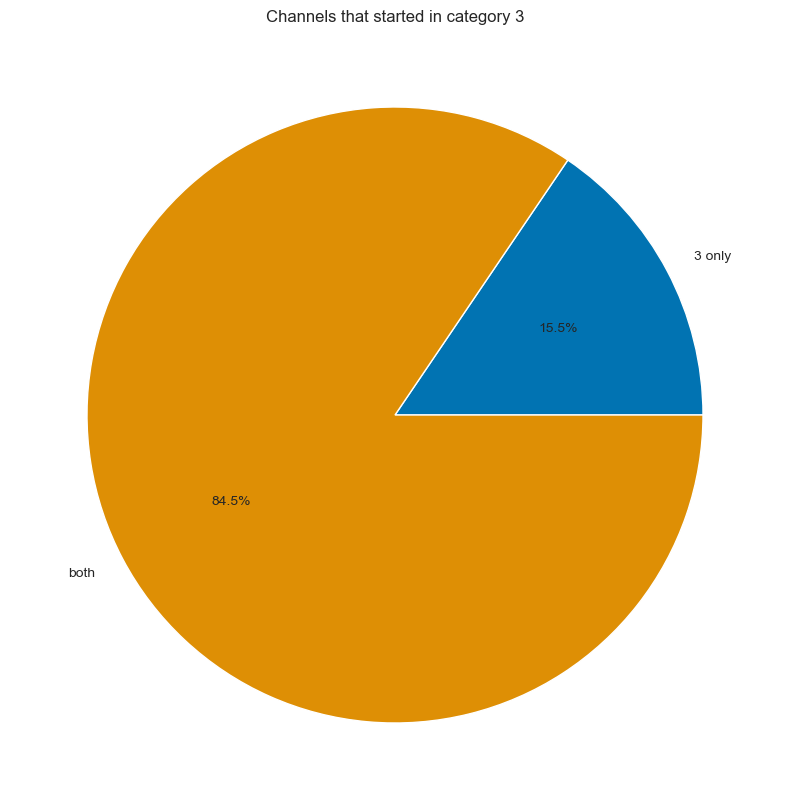

In [444]:
#take only the youtubers that started in category 3 
channels3 = monthly_data34[monthly_data34['monthly_rank'] == 3]['channel'].unique()

#take the youtubers that were in category 4
channels4 = monthly_data34[monthly_data34['monthly_rank'] == 4]['channel'].unique()

#take the youtubers that were in both categories
channels_both_34 = np.intersect1d(channels3,channels4)

#take the youtubers that were only in category 3 (so they did not change categories)
channels_only_3 = np.setdiff1d(channels3,channels_both_34)

#take the youtubers that were only in category 4 (or more)
channels_only_4 = np.setdiff1d(monthly_data34[monthly_data34['monthly_rank'] == 4]['channel'].unique(),channels_both_34)

#plot a pie chart of the number of channels that started in category 3 or 4
pieplot = pd.DataFrame({'category': ['3 only', 'both'], 'count': [channels_only_3.size, channels_both_34.size]})
pieplot.plot(kind='pie', y='count', labels=pieplot['category'], autopct='%1.1f%%', legend=False, figsize=(10, 10))
plt.title('Channels that started in category 3')
plt.ylabel('')
plt.show()

First thing to observe here , is that within people that started in category 3: 84.5% at least reached category 4 or more, and only 15.5% stayed there, that means that a lot of youtubers changed categories and improved within time.

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/1653088076.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/1653088076.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an under

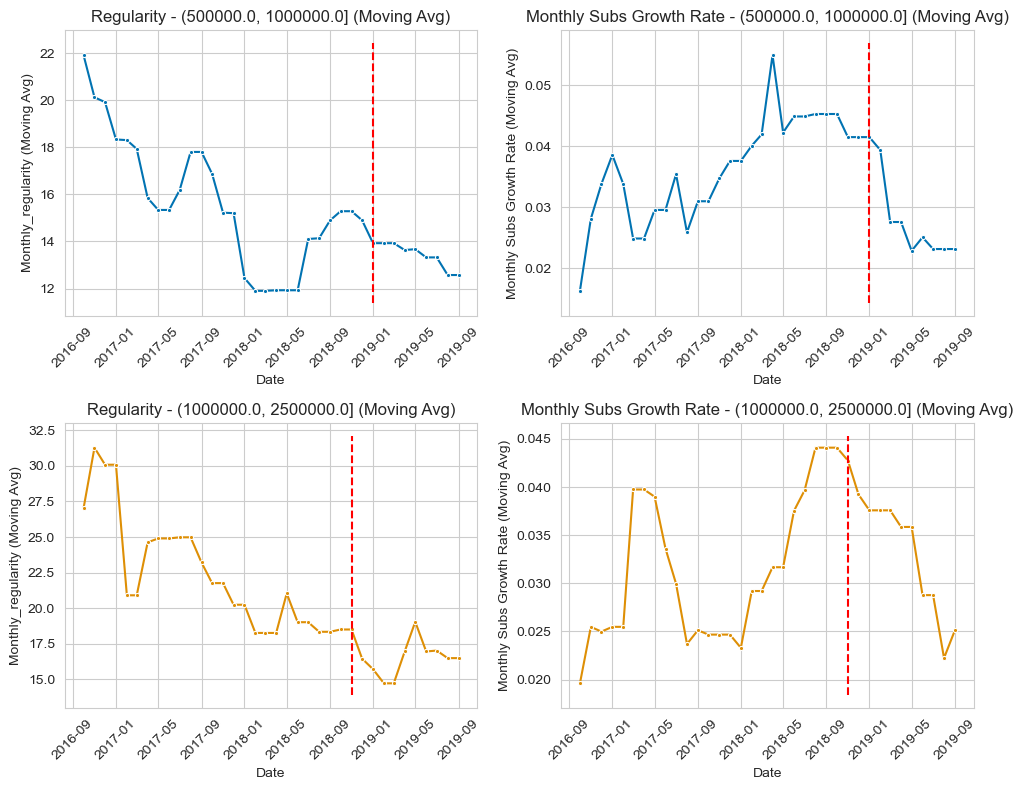

In [437]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'monthly_avg' is your DataFrame with 'year', 'month', 'monthly_subs_cat', 'monthly_vids', 'monthly_subs_growth'

# Combine 'year' and 'month' columns to create a 'date' column
channels34_avg['date'] = pd.to_datetime(channels34_avg['year'].astype(str) + '-' + channels34_avg['month'].astype(str))

# Get unique categories
categories = channels34_avg['monthly_subs_cat'].unique()

# Create a color palette for different categories
palette = sns.color_palette("colorblind", len(categories))

# Create 2x2 subplots (2categories, 2 plots each)
fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(10, 8))

# Plotting for each category with moving averages and different colors
for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = channels34_avg[channels34_avg['monthly_subs_cat'] == category]
    
    # Apply moving averages to number of videos per month
    category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).median()
    
    # Plotting number of videos per month with moving averages and different color
    sns.lineplot(data=category_data, x='date', y='monthly_regularity_ma', ax=axes[i, 0], marker='.', estimator=None, color=palette[i])
    axes[i, 0].set_title(f'Regularity - {category} (Moving Avg)')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Monthly_regularity (Moving Avg)')
    axes[i, 0].legend().remove()
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Apply moving averages to monthly subscription growth rate
    category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).median()
    
    # Plotting monthly subscription growth rate with moving averages and different color
    sns.lineplot(data=category_data, x='date', y='monthly_subs_growth_ma', ax=axes[i, 1], marker='.', estimator=None, color=palette[i])
    axes[i, 1].set_title(f'Monthly Subs Growth Rate - {category} (Moving Avg)')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Monthly Subs Growth Rate (Moving Avg)')
    axes[i, 1].legend().remove()
    axes[i, 1].tick_params(axis='x', rotation=45)

    # Plotting vertical lines at the points where the number channels within a cateory increased by 5 or more
    increase_points = category_data[category_data['channel'].diff()>=(5)]
    
    # Plot vertical lines at those points
    axes[i, 0].vlines(x=increase_points['date'].values, ymin=axes[i, 0].get_ylim()[0], ymax=axes[i, 0].get_ylim()[1], color='red', linestyles='dashed')
    axes[i, 1].vlines(x=increase_points['date'].values, ymin=axes[i, 1].get_ylim()[0], ymax=axes[i, 1].get_ylim()[1], color='red', linestyles='dashed')


    
plt.tight_layout()
plt.show()


"One important thing should be remarked. Even though no correlation is observed between the growth rate of subscribers and the regularity of YouTubers in categories 3 and 4, we can observe that the trend of YouTubers' growth rate and their regularity is similar between the two categories."

Moreover, we can also observe that the average growth rate observed a massive drop when the categories know an increase in the number of youtubers in which they are, and this probably because newly arrived youtubers do not have the same growth rate than those already present, even though they have a similar regularity. That may explain the negative correlation


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2369345670.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



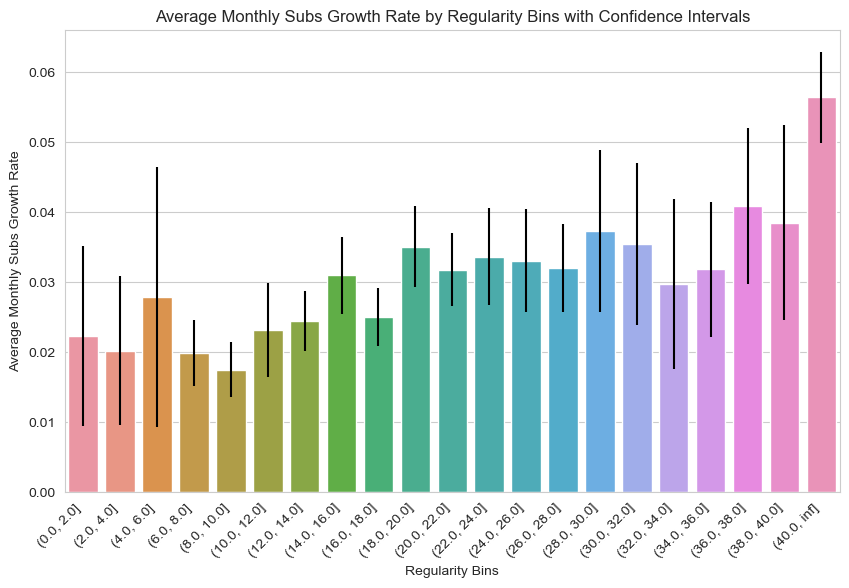

In [454]:

# Define bins for regularity manually
bins = list(range(0, 40, 2))
bins.append(40)
bins.append(np.inf)  # Define your own bins according to your data

# Create a new column with regularity bins
monthly_data34['regularity_bins'] = pd.cut(monthly_data34['monthly_regularity'], bins=bins)

# Calculate the mean and confidence intervals for each regularity bin
result = monthly_data34.groupby('regularity_bins')['monthly_subs_growth'].agg(['mean', 'std'])
result['CI'] = 1.96 * (result['std'] / np.sqrt(monthly_data34.groupby('regularity_bins')['monthly_subs_growth'].count()))

# Plotting with error bars (confidence intervals)
plt.figure(figsize=(10, 6))
sns.barplot(x=result.index, y=result['mean'], yerr=result['CI'], capsize=0.1)
plt.xlabel('Regularity Bins')
plt.ylabel('Average Monthly Subs Growth Rate')
plt.xticks(rotation=45, ha='right')
plt.title('Average Monthly Subs Growth Rate by Regularity Bins with Confidence Intervals')

plt.show()



/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2463314905.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



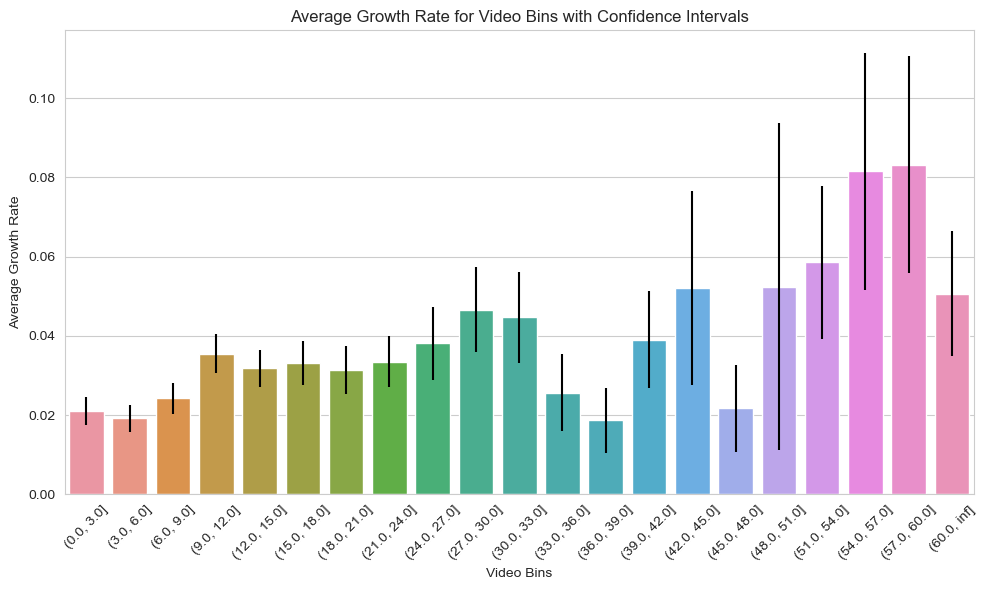

<Figure size 640x480 with 0 Axes>

In [455]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the channel data
# Replace 'regularity' and 'growth_rate' with the actual column names in your dataset

# Define bins for regularity manually
#arrange the bins such that each bin has the same number of videos
#arrange 0 to 100 with step 2


bins = list(range(0,62,3))
bins.append(np.inf)



# Create a new column with regularity bins
monthly_data34['vids_bins'] = pd.cut(monthly_data34['monthly_vids'], bins=bins)

# Calculate the mean and confidence intervals for each 'vids_bins'
result = monthly_data34.groupby('vids_bins')['monthly_subs_growth'].agg(['mean', 'std'])
result['CI'] = 1.96 * (result['std'] / np.sqrt(monthly_data34.groupby('vids_bins')['monthly_subs_growth'].count()))

# Reset index for Seaborn plotting
result = result.reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='vids_bins', y='mean', data=result, yerr=result['CI'])
plt.title('Average Growth Rate for Video Bins with Confidence Intervals')
plt.xlabel('Video Bins')
plt.ylabel('Average Growth Rate')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
plt.tight_layout()
plt.show()

The major think to remark here, is that even if for small regularities the average growth rate seems to be uncorrelated, we can not ignore the fact that youtubers with very high regularity have a significantly higher growth rate than those with lowe regularity.
When plotting the growth rate in function of the numbers of videos displayed per month, the values with high growth rate are between 27 and 33, between 42 and 45, and between 54 and 60, those ranges are not random, since they represent a high frequency of videos, but also a high regularity since it represents respectively around 1 video per day, 1.5 videos per day, and 2 videos per day.
To prove so we will check their timeseries.

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2752482912.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_26198/2752482912.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an under

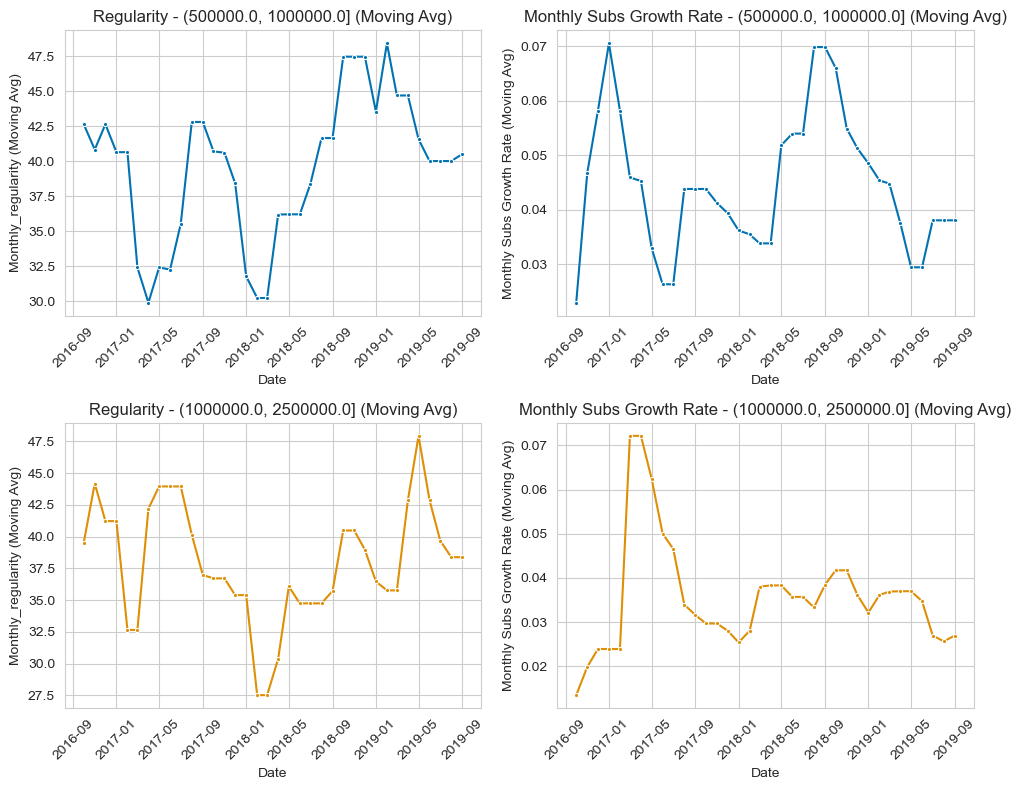

In [448]:
#take the youtubers that already have been in the bin (40, inf)
high_reg_ytbrs = monthly_data34[monthly_data34['regularity_bins'] == pd.Interval(40, np.inf)]['channel'].unique()

high_reg_data_34 = monthly_data34[monthly_data34['channel'].isin(high_reg_ytbrs)]


#same groupby as before but only for the channels that started in category 3 or 4
hr_34_avg  = high_reg_data_34.groupby(['year', 'month', 'monthly_rank']).agg({
    'monthly_subs_cat':'min',
    'monthly_vids': 'mean',
    'monthly_subs_growth': 'mean',
    'monthly_regularity': 'mean',
    'monthly_avg_likes_per_views': 'mean',
    'channel':'count'
}).reset_index()

hr_34_avg.sort_values(by=['year', 'month', 'monthly_rank'], ascending=[True, True, False], inplace=True)


# Assuming 'monthly_avg' is your DataFrame with 'year', 'month', 'monthly_subs_cat', 'monthly_vids', 'monthly_subs_growth'

# Combine 'year' and 'month' columns to create a 'date' column
hr_34_avg['date'] = pd.to_datetime(hr_34_avg['year'].astype(str) + '-' + hr_34_avg['month'].astype(str))

# Get unique categories_34
categories_34 = hr_34_avg['monthly_subs_cat'].unique()

# Create a color palette for different categories_34
palette = sns.color_palette("colorblind", len(categories_34))

# Create 2x2 subplots (2categories_34, 2 plots each)
fig, axes = plt.subplots(nrows=len(categories_34), ncols=2, figsize=(10, 8))

# Plotting for each category with moving averages and different colors
for i, category in enumerate(categories_34):
    # Filter data for the current category
    hr_cat_34 = hr_34_avg[hr_34_avg['monthly_subs_cat'] == category]
    
    # Apply moving averages to number of videos per month
    hr_cat_34['monthly_regularity_ma'] = hr_cat_34['monthly_regularity'].rolling(window=3, min_periods=1).median()
    
    # Plotting number of videos per month with moving averages and different color
    sns.lineplot(data=hr_cat_34, x='date', y='monthly_regularity_ma', ax=axes[i, 0], marker='.', estimator=None, color=palette[i])
    axes[i, 0].set_title(f'Regularity - {category} (Moving Avg)')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Monthly_regularity (Moving Avg)')
    axes[i, 0].legend().remove()
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Apply moving averages to monthly subscription growth rate
    hr_cat_34['monthly_subs_growth_ma'] = hr_cat_34['monthly_subs_growth'].rolling(window=3, min_periods=1).median()
    
    # Plotting monthly subscription growth rate with moving averages and different color
    sns.lineplot(data=hr_cat_34, x='date', y='monthly_subs_growth_ma', ax=axes[i, 1], marker='.', estimator=None, color=palette[i])
    axes[i, 1].set_title(f'Monthly Subs Growth Rate - {category} (Moving Avg)')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Monthly Subs Growth Rate (Moving Avg)')
    axes[i, 1].legend().remove()
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




In [449]:


correlation_data_34 = []
# Calculate and print spearman correlations for each category, only 
for category in categories_34:
    category_data_34 = hr_34_avg[hr_34_avg['monthly_subs_cat'] == category]
    spearman_corr = category_data_34[['monthly_regularity', 'monthly_subs_growth']].corr(method='spearman')
    spearman_corr_value = spearman_corr.iloc[0, 1]
    
    # Append correlation data to the list
    correlation_data_34.append({'Category': category, 'Spearman Correlation': round(spearman_corr_value, 2)})

# Create a DataFrame from the correlation data
correlation_34_df = pd.DataFrame(correlation_data_34, index = hr_34_avg['monthly_rank'].unique())

# Display the correlation table without index
display(correlation_34_df)











,Category,Spearman Correlation
4,"(500000.0, 1000000.0]",0.32
3,"(1000000.0, 2500000.0]",0.24


Well, first thing to observe here , is that correlation indeed increaded for youtubers that are very regular compared to the correlation computed previously, moreover, we can also observe that for those regular youtubers, neither the growth rate nor the regularity has a clear trend of increase or decrease but it naturally tends to fluctuate depending on the periods , and they have the same moves (sometimes the difference is more significant than others).

We actually also observe the jumps in regularity within the end of the years as we previously saw for other categories, so the behavior becomes similar to what's expected.


We can thus conclude that even for youtubers that have between 500k and 2.5M subscribers, being regular is a huge plus if you want to grow fastly.

And more generally, being regular , in terms of number of videos released each month, but also in terms of low volatility, helps you to grow faster as you tend to build viewers loyalty .